<a href="https://colab.research.google.com/github/tayaba02/Convolutional-Spiking-Neural-Network-for-Image-Classification-of-MNIST-dataset/blob/main/convolutional_spiking_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 3.3 MB/s 


In [ ]:
#Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import utils, nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import snntorch as snn
from snntorch import surrogate
import snntorch.functional as SF

In [ ]:
#Connect to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")

Device in use: cuda


In [ ]:
# User-specified batch size and data for MNIST
batch_size = 128
data_path='/data/mnist'

In [ ]:
# Define transformations
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [ ]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

Label for sample data: 5
Size of data: torch.Size([1, 28, 28])


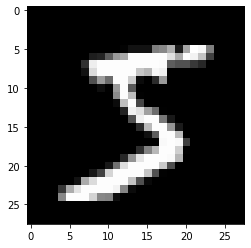

In [ ]:
sample_idx = 0
sample_data, sample_label =  mnist_train[sample_idx]
plt.imshow(sample_data[0], cmap="gray")
print(f"Label for sample data: {sample_label}")
print(f"Size of data: {sample_data.size()}")

In [ ]:
beta = 0.9
spike_grad = surrogate.fast_sigmoid(slope=25)### Insert surrogate gradient function here ###
step_num = 10

In [ ]:
class SNN_model(nn.Module):
    def __init__(self, num_steps, input_channel=1):
        super(SNN_model, self).__init__()
        self.num_steps = num_steps
        self.conv1 = nn.Conv2d(input_channel, 16, 5, 1, 2)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)### Insert LIF neuron here ###
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)### Insert LIF neuron here ###
        self.fc1 = nn.Linear(32*14*14, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)### Insert LIF neuron here ###

    def forward(self, x):
        batch_size_curr = x.shape[0] # Get current batch_size
        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()### Initialize the LIF neuron here ###
        mem2 = self.lif2.init_leaky()### Initialize the LIF neuron here ###
        mem3 = self.lif3.init_leaky()### Initialize the LIF neuron here ###

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        for step in range(self.num_steps):
            cur1 = self.pool(self.conv1(x))
            spk1, mem1 = self.lif1(cur1, mem1)### Generate spikes and membrane voltage by using the previous layer's output as injection current ###
            cur2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)### Generate spikes and membrane voltage by using the previous layer's output as injection current ###
            cur3 = self.fc1(spk2.view(batch_size_curr, -1))
            spk3, mem3 = self.lif3(cur3, mem3)### Generate spikes and membrane voltage by using the previous layer's output as injection current ###

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec), torch.stack(mem3_rec)

snn_model = SNN_model(step_num).to(device)
print(snn_model)

SNN_model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lif1): Leaky()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lif2): Leaky()
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
  (lif3): Leaky()
)


In [ ]:
optimizer_snn = torch.optim.Adam(snn_model.parameters(), lr=1e-2, betas=(0.9, 0.999))
loss_snn = nn.CrossEntropyLoss()

In [ ]:
epoch_num = 2

In [ ]:
*_, last_set = iter(train_loader)
data, targets = last_set
data = data.to(device)
targets = targets.to(device)
print(f"Shape of data: {data.shape}, Shape of targets: {targets.shape}")

Shape of data: torch.Size([96, 1, 28, 28]), Shape of targets: torch.Size([96])


In [ ]:
def train_snn(network, train_dl, num_epochs, num_steps):
    loss_hist = []
    acc_hist = []
    # training loop
    for epoch in range(num_epochs):
        for i, (data, targets) in enumerate(iter(train_dl)):
            data = data.to(device) # Tensor to be accelerated
            targets = targets.to(device) # Tensor to be accelerated

            network.train() # Set the mode to train
            spk_rec, mem_rec = network(data) ### Invoke network upon the data ###

            loss_val = torch.zeros((1), dtype=torch.float, device=device)
            for step in range(num_steps):
                loss_val += loss_snn(mem_rec[step], targets) ### Calculate the loss ###

            # Gradient calculation + weight update
            optimizer_snn.zero_grad()
            loss_val.backward()
            optimizer_snn.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

            # print every 25 iterations
            if i % 450 == 0:
                print(f"Epoch {epoch+1}, Batch {i+1} \nTrain Loss: {loss_val.item():.2f}")

                # check accuracy on a single batch
                acc = SF.accuracy_rate(spk_rec, targets)  ### Use SF's accuracy rate to calculate accuracy ###
                acc_hist.append(acc)
                print(f"Accuracy: {acc * 100:.2f}%\n")

def test_snn(network, test_dl, num_steps):
    size, correct = 0, 0
    loss_val = 0
    with torch.no_grad():
        network.eval()
        for data, targets in test_dl:
            data = data.to(device)
            targets = targets.to(device)

            test_spk, test_mem = network(data)

            _, predicted = test_spk.sum(dim=0).max(1) ### Obtain the predicted values based on spikes ###
            size += targets.size(0)
            correct += (predicted==targets).sum().item()
            loss_val += loss_snn(test_mem[num_steps-1], targets) ### Update the loss based on the last value of the spiking membrane voltage ###
    test_loss = loss_val/size
    print(f"Total correctly classified test set images: {correct}/{size}")
    print(f"Test set accuracy: {100 * correct/size:.2f}%, avg loss: {test_loss:>8f}")

In [ ]:
train_snn(snn_model, train_loader, epoch_num, step_num)

Epoch 1, Batch 1 
Train Loss: 23.00
Accuracy: 7.81%

Epoch 1, Batch 451 
Train Loss: 1.52
Accuracy: 94.53%

Epoch 2, Batch 1 
Train Loss: 1.29
Accuracy: 96.88%

Epoch 2, Batch 451 
Train Loss: 0.66
Accuracy: 93.75%



In [ ]:
test_snn(snn_model, test_loader, step_num)

Total correctly classified test set images: 9682/10000
Test set accuracy: 96.82%, avg loss: 0.001262
